# Import

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Recupération des données

In [95]:
df = pd.read_csv("data/train.csv", sep=',')

In [96]:
df.columns[159]

'PSASUGST'

In [97]:

A_garder = ['CRVCLHPV', 'HADHYST2', 'COLNSIGM', "COLNCNCR", 'VIRCOLO1', "SMALSTOL", 'STOOLDN2', 'SMOKE100', 'SMOKDAY2',
            'USENOW3', 'ECIGNOW2', 'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'LCSCTSC1', 'LCSSCNCR', 'ALCDAY4', 'AVEDRNK3',
            'DRNK3GE5', "MAXDRNKS", 'HIVRISK5', 'COVIDPOS', 'COVIDSMP', 'COVIDPRM', 'PDIABTS1', 'PREDIAB2', 'DIABTYPE',
            'FEETSORE', 'TOLDCFS', 'HAVECFS', 'COPDCOGH', 'COPDFLEM', 'COPDBRTH', 'COPDBTST', 'COPDSMOK', 'CNCRDIFF', 
            'CSRVDOC1', 'CSRVDEIN', 'CSRVPAIN', 'CSRVCTL2', 'PSATEST1', 'PCPSARS2']

# BLDSTFIT = blood test en fonction d'avant un autre test
# 'COLNTES1', 'HADSIGM4', "SIGMTES1", 'LASTSIG4', 'VCLNTES2', 'STOLTEST', 'SDNATES1', 'LCSCTWHN', 'HIVTSTD3, COVIDFS1, COVIDSE1, PSATIME1 : date des teste
# 'FLUSHOT7', 'FLSHTMY3', 'PNEUVAC4', 'HIVTST7, 'IMFVPLA3, HPVADVC4, HPVADSHT, COVIDVA1  : vaccins
peut_etre = ['COLNTES1', 'HADSIGM4', "SIGMTES1", 'LASTSIG4', 'VCLNTES2', 'STOLTEST', 'SDNATES1', 'LCSCTWHN', 'BLDSTFIT', 
             'FLUSHOT7', 'FLSHTMY3', 'PNEUVAC4', 'TETANUS1', 'HIVTST7', 'HIVTSTD3', 'IMFVPLA3', 'HPVADVC4', 'HPVADSHT',
             'SHINGLE2', 'COVIDVA1', 'COVIDNU1', 'COVIDFS1', 'COVIDSE1', 'PSATIME1'] 

A_enlever = ['INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'DIABEYE1', 'DIABEDU1', 'WORKCFS', 'CSRVSUM', 'CSRVRTRN', 'CSRVINST',
             'CSRVINSR', 'CSRVCLIN', 'PSASUGST']

In [ ]:
def plot_nan_proportion(df):
    """
    Affiche la proportion de valeurs manquantes (NaN) pour chaque colonne d'un DataFrame.
    """
    nan_proportion = df.isna().sum().sort_values(ascending=False) / len(df)

    plt.figure(figsize=(12, 6))
    plt.bar(nan_proportion.index, nan_proportion.values)
    plt.xticks(rotation=90)
    plt.ylabel("Proportion de NaN")
    plt.title("Proportion de valeurs manquantes par colonne")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    return nan_proportion

In [114]:
import yaml

with open('features.yaml', "r", encoding="utf-8") as yaml_file:
    yaml_content = yaml.load(yaml_file, Loader=yaml.SafeLoader)   

features = yaml_content['features']

In [117]:
df_clean = df[features]

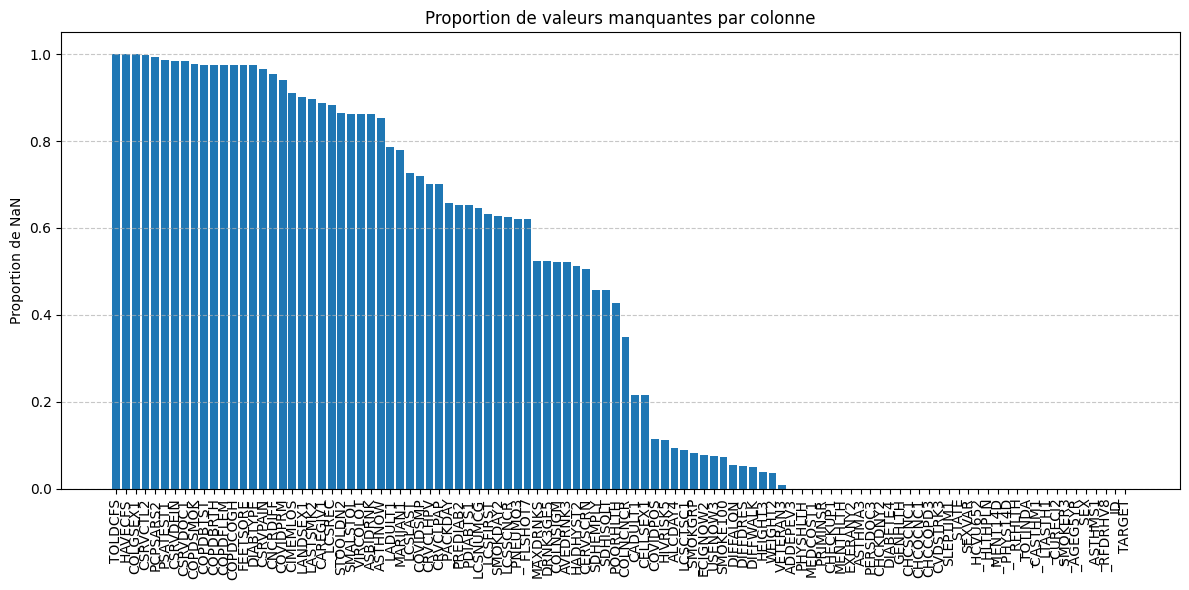

In [118]:
nan_proportion = plot_nan_proportion(df_clean)

In [121]:
def clean_data(df):
    nan_proportion = df.isna().sum().sort_values(ascending=False) / len(df)

    for i, prop in enumerate(nan_proportion.values):
        if prop > 0.95:
            print(nan_proportion.index[i])


In [122]:
clean_data(df_clean)

TOLDCFS
HAVECFS
COLGSEX1
CSRVCTL2
PCPSARS2
PSATEST1
CSRVDEIN
CSRVDOC1
COPDSMOK
COPDBTST
COPDBRTH
COPDFLEM
COPDCOGH
FEETSORE
DIABTYPE
CSRVPAIN
CNCRDIFF
